In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [15]:
fake_df = pd.read_csv('src/data/Fake.csv')
true_df = pd.read_csv('src/data/True.csv')

# Add label field
fake_df['label'] = 1
true_df['label'] = 0

# Merge the datasets
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


In [16]:
# Check for duplicates
print(f"Duplicate entries: {df.duplicated().sum()}")

# Drop duplicate entries
df = df.drop_duplicates().reset_index(drop=True)
print(f"Duplicate entries after cleaning: {df.duplicated().sum()}")

Duplicate entries: 209
Duplicate entries after cleaning: 0


In [17]:
# Check for missing values
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

Text(0, 0.5, 'Frequency')

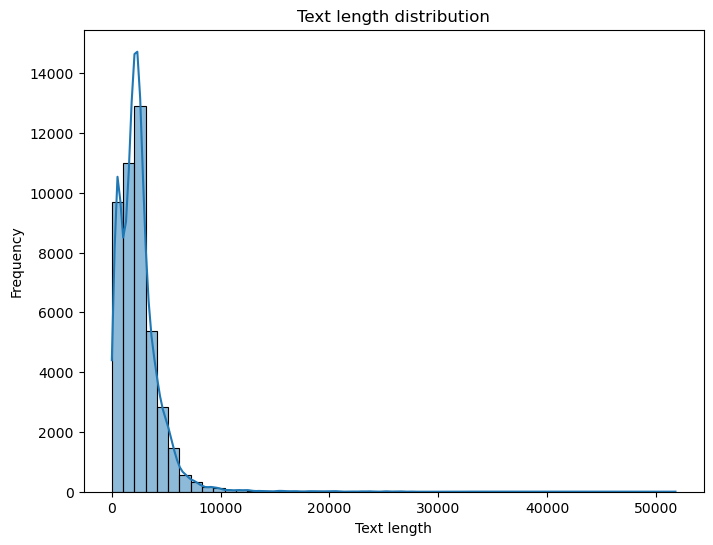

In [18]:
# Check the text length distribution
import matplotlib.pyplot as plt
import seaborn as sns

df['text_length'] = df['text'].str.strip().str.len().astype(int)

plt.figure(figsize=(8, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Text length distribution")
plt.xlabel('Text length')
plt.ylabel('Frequency')

In [19]:
too_long_or_too_short = len(df[(df['text_length']>5000) | (df['text_length'] < 50)])

print(f'Percentage of rows with too long or too short text: {too_long_or_too_short/len(df) * 100:.2f} %')

Percentage of rows with too long or too short text: 9.30 %


Because the number of rows that have too much or too little words in the text less than 10% of the dataset, we can sefely remove these rows.

In [20]:
# Drop rows with too much or too little text
df1 = df.copy()
df1 = df1[(df1["text_length"] > 50) & (df1["text_length"] < 5000)].reset_index(drop=True)

In [21]:
df1.loc[df1['label']==0, 'text'].iloc[2].replace("’", "").replace('“', '').replace('”', "")

'GLASGOW, Scotland (Reuters) - Most U.S. presidential candidates go abroad to sharpen their foreign policy credentials. Donald Trump arrives in Scotland on Friday to reopen a golf resort. The presumptive Republican nominee, 70, visits his familys ancestral homeland to showcase his far-flung business empire. His mother was born on Scotlands Isle of Lewis. With a throng of reporters watching, he will make a dramatic arrival by helicopter at his seaside Trump Turnberry resort. He has scheduled a news conference on the 9th hole at noon (7 a.m. ET/1100 GMT). His visit to Turnberry, to be followed by a stop at his resort in Aberdeen on Saturday, will allow him to comment on the outcome of Britains vote on Thursday on whether to remain in the European Union. I dont think opening a golf resort gets you many foreign policy chops, said Saul Anuzis, former chairman of the Michigan Republican Party. But since hes there right in the middle of the EU vote, it may end up being a PR bonanza for him. T

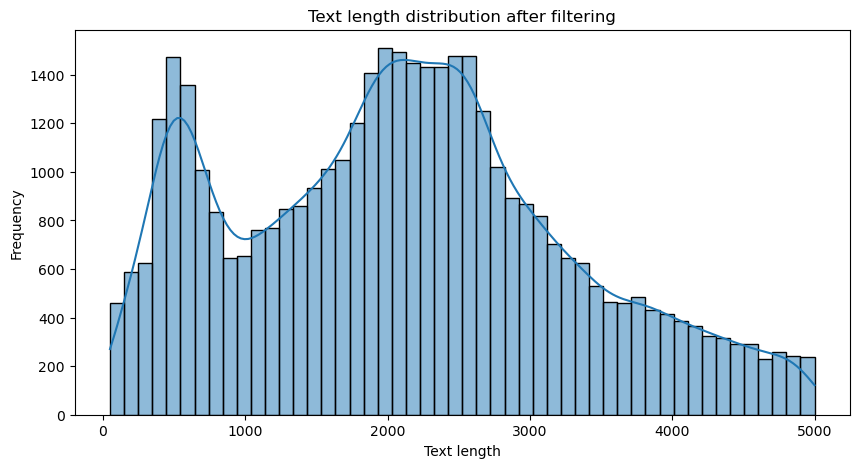

In [22]:
plt.figure(figsize=(10,5))
sns.histplot(df1["text_length"], bins=50, kde=True)
plt.xlabel("Text length")
plt.ylabel("Frequency")
plt.title("Text length distribution after filtering")
plt.show()

# Feature Extraction

In [23]:
# Dropping unnecessary columns
df2 = df1.copy()
df2.drop(columns=['text_length', 'date'], inplace=True)

<Axes: xlabel='label', ylabel='count'>

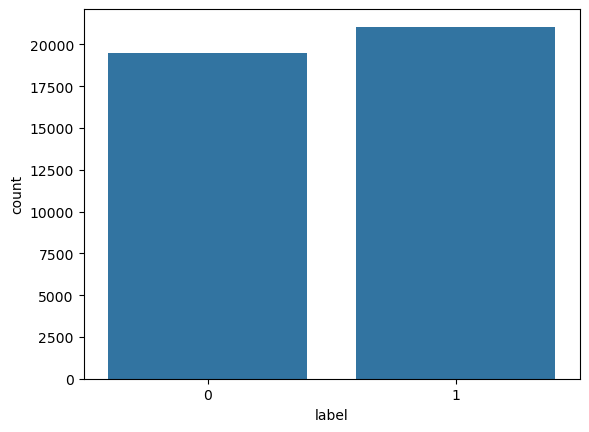

In [24]:
sns.countplot(x=df2['label'])

## TF-IDF Vectorization

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the text data
tfidf_vectorizer.fit(df2["text"])
X_tfidf = tfidf_vectorizer.transform(df2["text"])

# Convert to dense array
X_tfidf = X_tfidf.toarray()

# Check shape
print("TF-IDF Feature Shape:", X_tfidf.shape)

TF-IDF Feature Shape: (40525, 5000)


## Word Embeddings

For word embeddings, I am using pre-train word2vec embedding (GloVe: https://nlp.stanford.edu/pubs/glove.pdf)

In [ ]:
embeddings = {}

with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs

print(f"Loaded {len(embeddings)} word vectors.")
print(f'Encoding for dog: {embeddings.get("dog")}')

Loaded 400000 word vectors.
Encoding for dog: [ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.30569  

In [ ]:
def get_sentence_embedding(text):
    words = text.split()
    word_vectors = [embeddings[word] for word in words if word in embeddings]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(100)

# Apply function to dataset
X_embeddings = np.array([get_sentence_embedding(text) for text in df2["text"]])

print("Word Embedding Shape:", X_embeddings.shape)

Word Embedding Shape: (40525, 100)


In [13]:
df.iloc[2].text

'(Reuters) - Puerto Rico Governor Ricardo Rossello said on Wednesday he expected the federal government to waive the Jones Act, which would lift restrictions on ships that can provide aid to the island devastated by Hurricane Maria. He said he has been speaking with members of Congress from both parties who have supported an emergency waiver.  \xa0\xa0\xa0\xa0“We expect them to waive it,” Rossello said in an interview with CNN. He noted there was a seven-day waiver after Hurricane Irma, which was much less devastating to the island. \xa0\xa0\xa0 On Tuesday, the Trump administration said there was no need to waive shipping restrictions to help get fuel and supplies to storm-ravaged Puerto Rico, saying it would do nothing to address the island’s damaged ports, the main impediment to shipping. A waiver would allow Puerto Rico to get help not only from U.S. ships but from any ships that can bring aid. \xa0\xa0\xa0 “That is critical, particularly for fuel,” he said. “One of the consideratio

## Transformer Based word embeddings

In [ ]:
import pickle
from pathlib import Path

if Path('X_bert_embeddings.pkl').is_file():
    print('Loading X_bert_embeddings.pkl')

    with open('X_bert_embeddings.pkl', 'rb') as f:
        X_bert_embeddings = pickle.load(f)
    print('Embeddings loaded')
else:
    print('Generating X_bert_embeddings.pkl')
    %pip install transformers torch tqdm -v
    from tqdm.notebook import tqdm
    import torch
    from transformers import DistilBertTokenizer, DistilBertModel

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load DistilBERT tokenizer & model and move model to GPU
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)

    def get_bert_embeddings(text_list, model, tokenizer, device):
        tokenized = tokenizer(text_list, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**tokenized)

        return outputs.last_hidden_state.mean(dim=1)  # Mean pooling over token embeddings

    # Move Data to GPU Batch by Batch
    X_bert_embeddings = []

    for text in tqdm(df2['text']):
        embedding = get_bert_embeddings([text], bert_model, tokenizer, device)
        X_bert_embeddings.append(embedding.cpu())  # Move back to CPU to avoid memory overflow

    # Convert List to Tensor
    X_bert_embeddings = torch.cat(X_bert_embeddings, dim=0)

    print(X_bert_embeddings.shape)

    # Save X_bert_embeddings
    with open('X_bert_embeddings.pkl', 'wb') as f:
        pickle.dump(X_bert_embeddings, f)

Loading X_bert_embeddings.pkl
Embeddings loaded


# Model Training

## Baseline Model: Logistic Regressor

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

y = df2['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

logistic_regressor = LogisticRegression()

logistic_regressor.fit(X_train, y_train)

y_pred_logistic = logistic_regressor.predict(X_test)

print(f'Accuracy Score', accuracy_score(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic, digits=4))

Accuracy Score 0.9861813695249846
              precision    recall  f1-score   support

           0     0.9837    0.9873    0.9855      3862
           1     0.9884    0.9852    0.9868      4243

    accuracy                         0.9862      8105
   macro avg     0.9861    0.9862    0.9862      8105
weighted avg     0.9862    0.9862    0.9862      8105



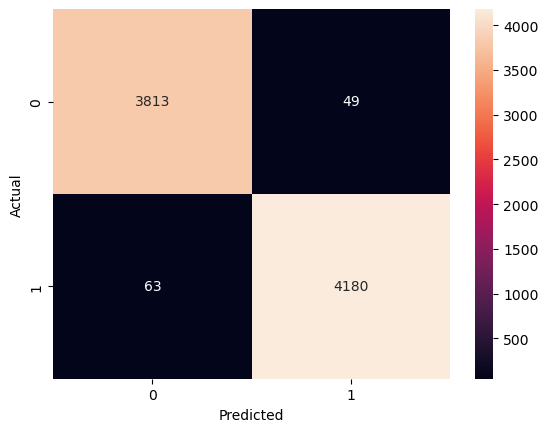

In [16]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred_logistic), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
# Checking for overfitting
from sklearn.model_selection import cross_val_score

train_acc = logistic_regressor.score(X_train, y_train)
test_acc = logistic_regressor.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

cv_scores = cross_val_score(logistic_regressor, X_tfidf, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Training Accuracy: 0.9905
Test Accuracy: 0.9862
Cross-Validation Scores: [0.98433066 0.9885256  0.98556447 0.9879087  0.98618137]
Mean CV Accuracy: 0.9865021591610116


We don't suspect any overfitting. The model performs very well!

In [34]:
import joblib

with open('src/model/logistic_regressor.mod', 'wb') as f:
    joblib.dump(logistic_regressor, f)
with open(vectorizer_path, 'wb') as f:
    joblib.dump(tfidf_vectorizer, f)

In [33]:
from pathlib import Path
# Load the saved model and TF-IDF vectorizer
model_path = Path('src/model/logistic_regressor.mod')
vectorizer_path = Path('src/model/tfidf_vectorizer.mod')

with open(model_path, "rb") as f:
    model = joblib.load(f)

with open(vectorizer_path, "rb") as f:
    vectorizer = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'src\\model\\tfidf_vectorizer.mod'

In [32]:
text = pd.read_csv("src/data/True.csv").text
text_vector = tfidf_vectorizer.transform(text).toarray()
model.predict(text_vector).max()

1

In [40]:
texts = tfidf_vectorizer.transform([df1.loc[df1['label']==1, 'text'].iloc[2]])
texts = texts.toarray()
logistic_regressor.predict(texts)

array([1])

## LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

# Define LSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=100),
    LSTM(128, return_sequences=True),  # First LSTM Layer
    Dropout(0.5),
    LSTM(64, return_sequences=False),  # Second LSTM Layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(X_embeddings, y, batch_size=32, epochs=5, validation_split=0.2)


Epoch 1/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5266 - loss: 0.6881 - val_accuracy: 0.7078 - val_loss: 0.5840
Epoch 2/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7063 - loss: 0.5846 - val_accuracy: 0.7078 - val_loss: 0.5805
Epoch 3/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.6797 - loss: 0.5966 - val_accuracy: 0.7076 - val_loss: 0.5844
Epoch 4/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7101 - loss: 0.5817 - val_accuracy: 0.7078 - val_loss: 0.5814
Epoch 5/5
1014/1014 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7061 - loss: 0.5800 - val_accuracy: 0.7077 - val_loss: 0.5806


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

# Define LSTM Model
model2 = Sequential([
    # Embedding(input_dim=5000, output_dim=100), # Remove Embedding layer as we are using pre-trained embeddings
    LSTM(128, return_sequences=True),  # First LSTM Layer
    Dropout(0.5),
    LSTM(64, return_sequences=False),  # Second LSTM Layer
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
# Compile Model
model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train Model
# Convert X_bert_embeddings to NumPy array with float32 data type
X_bert_embeddings_np = X_bert_embeddings.cpu().numpy().astype('float32')
X_bert_embeddings_np = X_bert_embeddings_np.reshape(X_bert_embeddings_np.shape[0], 1, X_bert_embeddings_np.shape[1])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_bert_embeddings.cpu().numpy().astype('float32'),  # Convert to NumPy array
    y,
    test_size=0.2,  # Proportion of data for testing
    random_state=42  # Set random seed for reproducibility
)

# Reshape the training and testing data
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Train the model on the training set
model2.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

# Evaluate the model on the testing set
y_pred_probs = model2.predict(X_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels, digits=4))

Epoch 1/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9118 - loss: 0.2398 - val_accuracy: 0.9800 - val_loss: 0.0590
Epoch 2/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9779 - loss: 0.0631 - val_accuracy: 0.9866 - val_loss: 0.0405
Epoch 3/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9807 - loss: 0.0551 - val_accuracy: 0.9849 - val_loss: 0.0424
Epoch 4/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9854 - loss: 0.0415 - val_accuracy: 0.9884 - val_loss: 0.0319
Epoch 5/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9832 - loss: 0.0470 - val_accuracy: 0.9892 - val_loss: 0.0318
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0     0.9861    0.9891    0.9876      3862
           1     0.9901    0.9873    0.9887      4243

    accuracy                         0.9882      8105
   macro avg     0.9881    0.9882    0.9881      8105
weighted avg     0.9882    0.9882    0.9882  

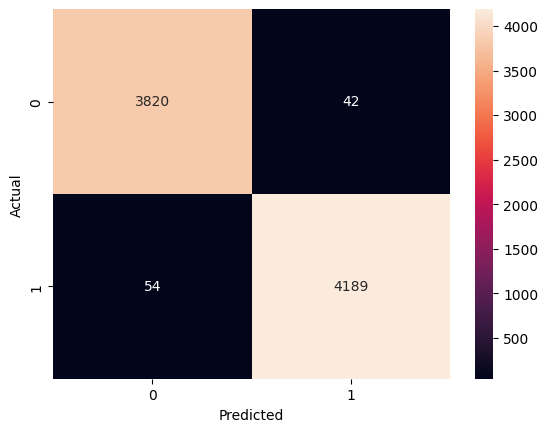

In [19]:
sns.heatmap(confusion_matrix(y_test, y_pred_labels), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# Define LSTM Model
model3 =Sequential([
    # Embedding(input_dim=5000, output_dim=100),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Normalize activations
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile Model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training set
model3.fit(X_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

# Evaluate the model on the testing set
y_pred_probs = model3.predict(X_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred_labels, digits=4))


Epoch 1/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9429 - loss: 1.5150 - val_accuracy: 0.9252 - val_loss: 0.2973
Epoch 2/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9631 - loss: 0.1967 - val_accuracy: 0.9650 - val_loss: 0.1790
Epoch 3/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9660 - loss: 0.1858 - val_accuracy: 0.9746 - val_loss: 0.1605
Epoch 4/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9649 - loss: 0.1817 - val_accuracy: 0.9668 - val_loss: 0.1758
Epoch 5/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9679 - loss: 0.1752 - val_accuracy: 0.9844 - val_loss: 0.1306
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0     0.9772    0.9899    0.9835      3862
           1     0.9907    0.9790    0.9848      4243

    accuracy                         0.9842      8105
   macro avg     0.9840    0.9845    0.9842      8105
weighted avg     0.9843    0.9842    0.9842 

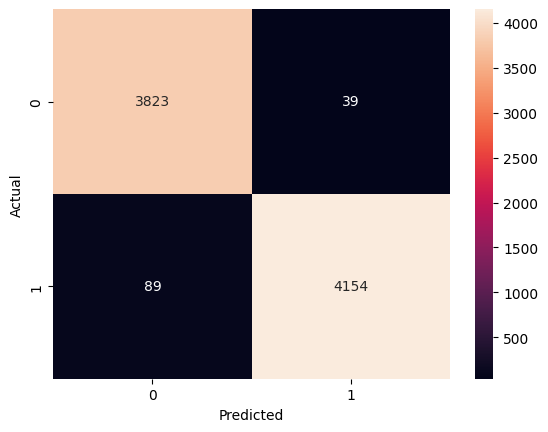

In [21]:
sns.heatmap(confusion_matrix(y_test, y_pred_labels), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Logistic regression with Transformer Embeddings

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

logistic_regressor_with_embeddings = LogisticRegression()

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[2])
logistic_regressor_with_embeddings.fit(X_train_reshaped, y_train)

y_pred_logistic = logistic_regressor_with_embeddings.predict(X_test_reshaped)

print(f'Accuracy Score', accuracy_score(y_test, y_pred_logistic))
print(classification_report(y_test, y_pred_logistic, digits=4))

Accuracy Score 0.9914867365823565
              precision    recall  f1-score   support

           0     0.9879    0.9943    0.9911      3862
           1     0.9948    0.9889    0.9918      4243

    accuracy                         0.9915      8105
   macro avg     0.9913    0.9916    0.9915      8105
weighted avg     0.9915    0.9915    0.9915      8105



The logisitc regressor with IDF Vectorized text vectors give a comparable performance with the best model while being simpler than the transformer embeddings. So we select the base model as the best model.

In [36]:
import joblib

with open('src/model/fake_news_detector.mod','wb') as f:
    joblib.dump(logistic_regressor, f)